In [57]:
import numpy as np
import numpy.linalg as la
import numpy.linalg as la
import matplotlib.pyplot as plt
from solve_hand_to_mouth import *
from copy import deepcopy
from estimation import *

%load_ext autoreload
%autoreload 2

# %pip install EconModel
from Model import ReferenceDependenceClass
model = ReferenceDependenceClass()
model.par.full_sample_estimation = True
model.allocate()
model_standard = deepcopy(model)    # Used later for standard model
model.par.model = 'HTM'
model_standard.par.model = 'HTM'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Estimating using the full sample** #
(using hazard rates from both before and after the reform)

# Model with reference dependence

In [58]:
# Setup
model.par.eta = 1  # Reference dependence
model.par.types = 1  # No heterogeneity
model.allocate()

# Estimation setup
est_par = ['delta', 'gamma', 'lambdaa', 'N', 'cost1'] # Parameters to estimate
theta0 = [0.95, 0.1, 1.0, 10, 100.0]  # Initial guesses
bounds = [(0.5, 1), (0.001, 10.0), (0.0, 10.0), (0,50), (0.0,500)] # Bounds for the parameters


#  Random starting values:
model.par.noOfParams = len(est_par)
model.par.noSearchInits = 1
np.random.seed(180615)

est_best = np.inf

for i in range(model.par.noSearchInits):

    theta0 = [np.random.uniform(model.par.lb_delta, model.par.ub_delta),
            np.random.uniform(model.par.lb_gamma,model.par.ub_gamma),
            np.random.uniform(model.par.lb_lambdaa,model.par.ub_lambdaa),
            np.random.uniform(model.par.lb_N,model.par.ub_N),
            np.random.uniform(model.par.lb_c,model.par.ub_c)]

    try:
        # Perform the method of simulated moments
        est = method_simulated_moments(model, est_par, theta0, bounds, weight=False)
        # print(est.fun)

        # Check if the current estimate is better than the best estimate
        if est.fun < est_best:
            est_best = est.fun
            par = est.x
            nit = est.nit
            jac = est.jac
            obj_ref = est_best

    except Exception as e:
        # Print the exception message and continue with the next iteration
        print(f"Iteration {i} failed with error: {e}")
        continue

d:\OneDrive\KU - Økonomi\Dynamic Programming\Term_Paper\Dynamic-programming-project\solve_hand_to_mouth.py:17: RuntimeWarning: invalid value encountered in scalar divide
  V = consumption_utility(c)/(1-par.delta)  + par.eta * np.sum(ref_diffs) # value of getting employed at time t


In [59]:
# Calculates jacobian based on small changes (epsilon)
def manual_jacobian(model, est_par, par, epsilon=1e-5):
    '''Calculate the Jacobian using finite differences'''
    baseline_moments = model_moments_combined(model, est_par, par)
    num_moments = len(baseline_moments)
    num_params = len(est_par)
    
    jacobian = np.zeros((num_moments, num_params))  # Set up empty matrix to store the jacobian
    
    for i in range(num_params): # Loop over the parameters
        new_par = np.array(par) # Copy the parameter vector
        new_par[i] += epsilon   # Add a small perturbation to the i-th parameter
        perturbed_moments = model_moments_combined(model, est_par, new_par) # Calculate the moments with the perturbed parameter
        jacobian[:, i] = (perturbed_moments - baseline_moments) / epsilon   # Calculate the i-th column of the jacobian
        new_par = np.array(par) # Reset vector to the original parameter vector for the next iteration
    
    return jacobian

jacobian = manual_jacobian(model, est_par, par)

print(jacobian)
print(jacobian.shape)


[[ 3.28688905e-01  1.51768029e-01  8.69769161e-03  0.00000000e+00
  -1.46349687e-04]
 [ 3.20345469e-01  1.48637470e-01  8.24558257e-03  0.00000000e+00
  -1.41683736e-04]
 [ 3.12447358e-01  1.45366075e-01  7.78541928e-03  0.00000000e+00
  -1.36946855e-04]
 [ 3.05121837e-01  1.41979400e-01  7.32022139e-03  0.00000000e+00
  -1.32181013e-04]
 [ 2.98505163e-01  1.38515158e-01  6.85385112e-03  0.00000000e+00
  -1.27440823e-04]
 [ 2.92740625e-01  1.35026099e-01  6.39114278e-03  0.00000000e+00
  -1.22795976e-04]
 [ 2.87976060e-01  1.31583336e-01  5.93805112e-03  0.00000000e+00
  -1.18334142e-04]
 [ 2.84360828e-01  1.28280164e-01  5.50183024e-03  0.00000000e+00
  -1.14164572e-04]
 [ 2.82042135e-01  1.25236464e-01  5.09126572e-03  0.00000000e+00
  -1.10422717e-04]
 [ 2.81160343e-01  1.22603814e-01  4.71699884e-03  0.00000000e+00
  -1.07276422e-04]
 [ 2.81842480e-01  1.20571516e-01  4.39200852e-03  0.00000000e+00
  -1.04934648e-04]
 [ 2.84192346e-01  1.19373944e-01  4.13235708e-03  0.00000000e+00

In [60]:
def standard_errors(jac, weight_matrix, N = 70):
    variance = np.zeros(jac.shape[1])*np.nan
    for i in range(jac.shape[1]):
        jac_i = jac[:, i].reshape(-1, 1)

        if np.all(jac_i == 0):
            print(f"Column {i} of the Jacobian is zero, cannot compute standard errors.")
            continue
        # diagonal Variance matirx for data moments
        omega_matrix = np.diag(np.diag(weight_matrix))

        # Compute (G'WG)
        gwg_inv = la.pinv(jac_i.T @ weight_matrix @ jac_i)

        # Compute the middle term G'WVW'G
        middle_term =  jac_i.T @ weight_matrix @ omega_matrix @ weight_matrix.T @ jac_i

        # Compute the variance
        variance[i] = gwg_inv @ middle_term @ gwg_inv
 
    standard_errors = np.sqrt(variance/N)
    
    return standard_errors

standard_errs = standard_errors(jacobian, model.data.weight_mat)

# print("Standard Errors:")
# print(standard_errs)


print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15} {"Std. Error":<15}')
for param, estimate, error in zip(est_par, par, standard_errs):
    print(f'{param:<15} {estimate:>15.3f} {error:>15.3f}')
print(f'Objective:               {est_best:.4f}')
print(f'Number of iterations:    {nit}')      
    

Column 3 of the Jacobian is zero, cannot compute standard errors.
Optimization Results:
---------------------
Parameter       Estimate        Std. Error     
delta                     0.867           0.000
gamma                     0.791           0.000
lambdaa                   4.396           0.011
N                        18.442             nan
cost1                   339.235           0.483
Objective:               0.3253
Number of iterations:    22


C:\Users\rasmu\AppData\Local\Temp\ipykernel_12552\3391549759.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  variance[i] = gwg_inv @ middle_term @ gwg_inv


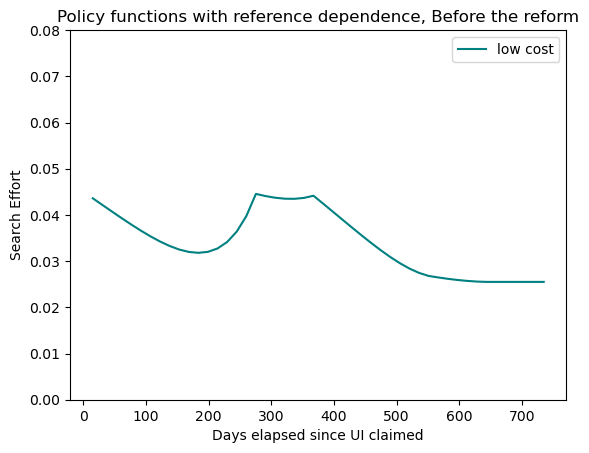

In [61]:
# Plot policy functions
search_effort_reference = solve_search_effort_HTM(model.par)
time = np.linspace(0, model.par.T, model.par.T)
plt.plot((time+1)*15, search_effort_reference[0,:], label = 'low cost', color='teal') 
# plt.plot((time+1)*15, search_effort[1,:], label = 'medium cost', color='orange') 
#plt.plot(time, search_effort[2,:], label = 'high' ) 
#plt.text(0.5, 0.96, '(Note that high cost is 0)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions with reference dependence, Before the reform')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

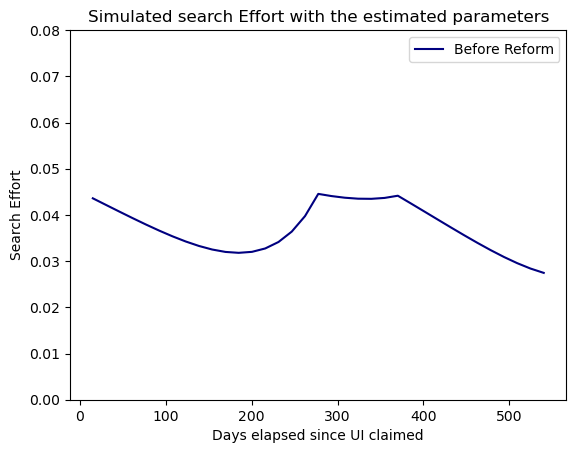

In [62]:
# Policy function before reform
search_reference_beforeReform = sim_search_effort_HTM(model.par)
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, search_reference_beforeReform, color='navy', label='Before Reform') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.ylim(0.0, 0.08)
plt.legend()
plt.show()

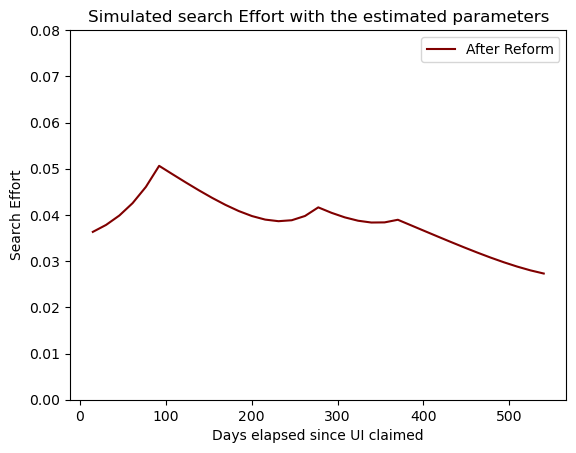

In [63]:
# Policy function after reform
model_afterReform = deepcopy(model)
model_afterReform.par.b1 = 342.0/675.0      # Value after reform
model_afterReform.par.b2 = 171.0/675.0      # Value after reform

model_afterReform.allocate()
search_reference_afterReform = model_afterReform.solve()

# true_data_outofsample = model.data.moments_after
# true_data_insample = model.data.moments_before
# mse_eta1_outofsample = np.mean((true_data_outofsample - s_forecast)**2)
# mse_eta1_insample = np.mean((true_data_insample - sim)**2)

# Now plotting s_forecast
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, search_reference_afterReform, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

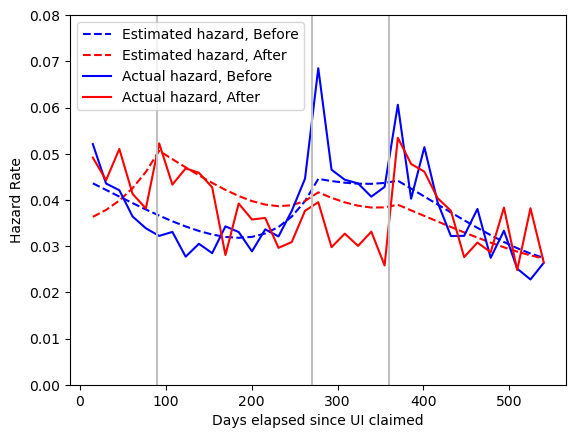

In [64]:
#Replicating figure 7(b) from the paper
after = model_standard.data.moments_after
before = model_standard.data.moments_before

time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, search_reference_beforeReform, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, search_reference_afterReform, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
# plt.title('Real and estimated hazard rates of the reference denpendence model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# Model with **NO** reference dependence (standard model)

In [65]:
# Setup
model_standard.par.eta = 0.0     # Removes reference dependence
model_standard.par.types = 3    # Allow for heterogeneity
model_standard.allocate()

# Estimation setup
est_par = ['delta','gamma', 'cost1', 'cost2', 'cost3', 'type_shares1', 'type_shares3'] # Parameters to estimate
theta0 = [0.9, 0.9, 84, 242, 310, 0.4, 0] # Initial guesses
bounds = [(0.5,1.0), (0.001, 50.0), (0.0, 100), (30, 300), (300, 1000), (0,0.9), (0,1-model_standard.par.type_shares1)] # Bounds for the parameters

# Random starting values
model.par.noOfParams = len(est_par)
model.par.noSearchInits = 1
np.random.seed(180615)

est_best = np.inf

for i in range(model.par.noSearchInits):

    theta0 = [np.random.uniform(model.par.lb_delta, model.par.ub_delta),
              np.random.uniform(model.par.lb_gamma,model.par.ub_gamma),
              np.random.uniform(model.par.lb_lsc,model.par.ub_lsc),
              np.random.uniform(model.par.lb_msc,model.par.ub_msc),
              np.random.uniform(model.par.lb_hsc,model.par.ub_hsc),
              np.random.uniform(model.par.lb_share,model.par.ub_share),
              np.random.uniform(model.par.lb_share,model.par.ub_share)]
    
    try:
        # Perform the method of simulated moments
        est = method_simulated_moments(model_standard, est_par, theta0, bounds, weight=False)

        # Check if the current estimate is better than the best estimate
        if est.fun < est_best:
            est_best = est.fun
            par = est.x
            nit = est.nit
            obj_standard = est_best

    except Exception as e:
        # Print the exception message and continue with the next iteration
        print(f"Iteration {i} failed with error: {e}")
        continue
   


print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, par):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est_best:.4f}')
print(f'Number of iterations:    {nit}')

Optimization Results:
---------------------
Parameter       Estimate       
delta                     0.886
gamma                     0.547
cost1                    23.495
cost2                    91.938
cost3                   578.459
type_shares1              0.348
type_shares3              0.000
Objective:               0.4107
Number of iterations:    44


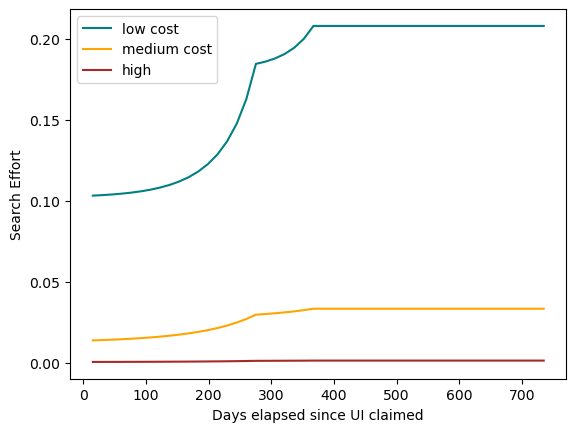

In [66]:
# Plot policy functions
search_effort_standard = solve_search_effort_HTM(model_standard.par)
time = np.linspace(0, model_standard.par.T, model_standard.par.T)
plt.plot((time+1)*15, search_effort_standard[0,:], label = 'low cost', color='teal') 
plt.plot((time+1)*15, search_effort_standard[1,:], label = 'medium cost', color='orange') 
plt.plot((time+1)*15, search_effort_standard[2,:], label = 'high', color='brown' ) 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
# plt.title('Policy functions standard model, After the reform')
plt.legend()
plt.show()

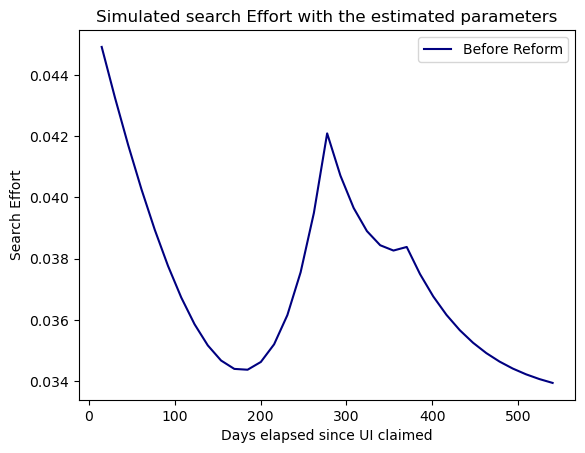

In [67]:
# Policy function before reform
model_standard.par.b1 = 222/675*model_standard.par.w    # High transfers
model_standard.par.b2 = model_standard.par.b1    # Medium transfers
model_standard.allocate()
search_standard_beforeReform = sim_search_effort_HTM(model_standard.par)
time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)
plt.plot((time+1)*15, search_standard_beforeReform, label='Before Reform', color='navy') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
# plt.ylim(0.0, 0.08)
plt.show()


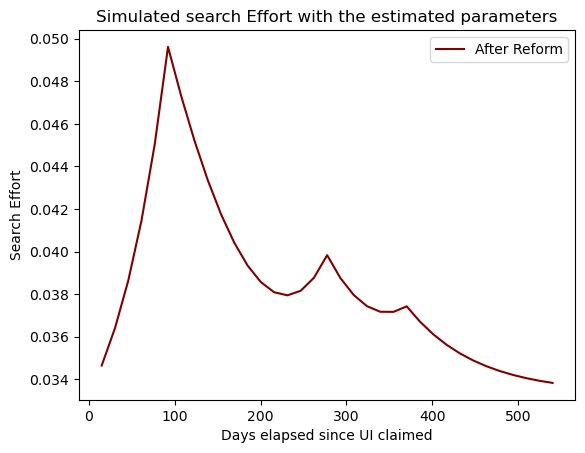

In [68]:
# Policy function after reform
model_standard.par.b1 = 342.0/675.0      # Value after reform
model_standard.par.b2 = 171.0/675.0      # Value after reform

model_standard.allocate()
search_standard_afterReform = sim_search_effort_HTM(model_standard.par)


# Now plotting s_forecast
time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)
plt.plot((time+1)*15, search_standard_afterReform, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
# plt.ylim(0.0, 0.08)
plt.show()

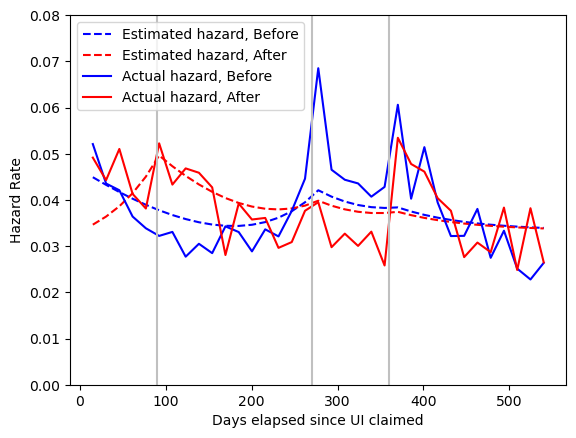

In [69]:
#Replicating figure 7(a) from the paper

time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)
plt.plot((time+1)*15, search_standard_beforeReform, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, search_standard_afterReform, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
# plt.title('Real and estimated hazard rates of the standard model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# **Comparison of the standard model and reference dependence**
### Through the Mean Square Error

In [70]:
# true_data_afterReform = model_standard.data.moments_after
# true_data_beforeReform = model_standard.data.moments_before

# # Get the mean square errors
# mse_standard_afterReform = np.mean((true_data_afterReform - search_standard_afterReform)**2)
# mse_standard_beforeReform = np.mean((true_data_beforeReform - search_standard_beforeReform)**2)

# # Comparison after reform
# comparison1 = "smaller" if mse_reference_afterReform < mse_standard_afterReform else "bigger" if mse_reference_afterReform > mse_standard_afterReform else "equal"
# comparison2 = "WITH reference dependence" if mse_reference_afterReform < mse_standard_afterReform else "WITHOUT reference dependence" 

# # Comparison before reform
# comparison3 = "smaller" if mse_reference_beforeReform < mse_standard_beforeReform else "bigger" if mse_reference_beforeReform > mse_standard_beforeReform else "equal"
# comparison4 = "WITH reference dependence" if mse_reference_beforeReform < mse_standard_beforeReform else "WITHOUT reference dependence"


# print("Before the reform: ")
# print("-" * 100)
# print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_reference_beforeReform}")
# print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_standard_beforeReform}")
# print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison3}\033[0m than the model without.")
# print(f"Best model: \033[1m{comparison4}\033[0m.")
# print("-" * 100)



# print("After the reform:")
# print("-" * 100)
# print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_reference_afterReform}")
# print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_standard_afterReform}")
# print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison1}\033[0m than the model without.")
# print(f"Best model: \033[1m{comparison2}\033[0m.")
# print("-" * 100)

### Through objective function

In [71]:
# Comparison
comparison1 = "Reference Dependent Model" if obj_ref < obj_standard else "Standard Model" if obj_ref > obj_standard else "They are equally good"


print("Comparison: ")
print("-" * 100)
print(f"The objective function from the model \033[1mwith\033[0m reference dependence is {obj_ref}")
print(f"The objective function from the model \033[1mwithout\033[0m reference dependence is {obj_standard}")
print(f"Best model: \033[1m{comparison1}\033[0m.")
print("-" * 100)

Comparison: 
----------------------------------------------------------------------------------------------------
The objective function from the model with reference dependence is 0.3253071141044784
The objective function from the model without reference dependence is 0.4107339012212794
Best model: Reference Dependent Model.
----------------------------------------------------------------------------------------------------


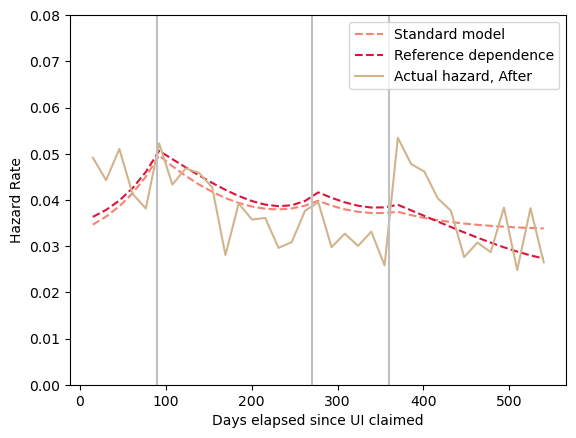

In [72]:
after = model_standard.data.moments_after

time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)     # x-axis
plt.plot((time+1)*15, search_standard_afterReform, label='Standard model', color='salmon', linestyle='--')                     # Model with no reference dependence
plt.plot((time+1)*15, search_reference_afterReform, label='Reference dependence', color='crimson', linestyle='--')                         # Model with reference dependence
plt.plot((time+1)*15, after, label='Actual hazard, After', color='tan')                        # True data
# Make a vertical line at 90, 270 and 360
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
# plt.title('Real and estimated hazard rates before the reform')
plt.ylim(0.0, 0.08)
plt.show()

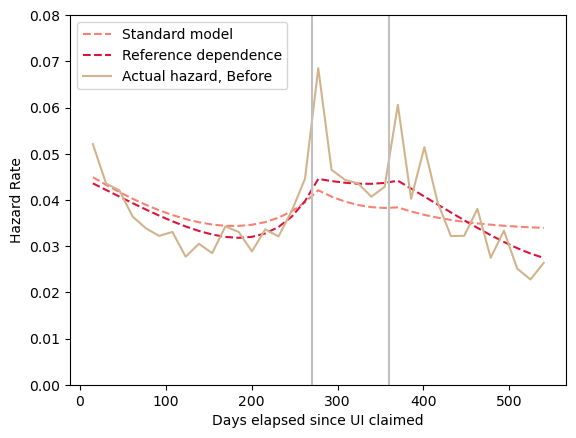

In [73]:
before = model_standard.data.moments_before

time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)     # x-axis
plt.plot((time+1)*15, search_standard_beforeReform, label='Standard model', color='salmon', linestyle='--')                            # Model with no reference dependence
plt.plot((time+1)*15, search_reference_beforeReform, label='Reference dependence', color='crimson', linestyle='--')                                # Model with reference dependence
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='tan')                           # True data
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
# plt.title('Real and estimated hazard rates before the reform')
plt.ylim(0.0, 0.08)
plt.show()